In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest,chi2,f_classif
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,precision_score,recall_score,f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [3]:
train=pd.read_csv('./train.csv')
test=pd.read_csv('./test.csv')
sample=pd.read_csv('./sample_submission.csv')
print(train.shape)
print(test.shape)
train.head(10)

(610310, 15)
(152578, 14)


,user_id,video_id,video_duration,watch_time,liked,commented,subscribed_after,category,device,watch_time_of_day,recommended,clicked,timestamp,watch_percent,id
0,59445,40936,1134.886052,1287.412446,1,0,0,Sports,Tablet,Afternoon,1,0.0,2025-09-07 02:10:34,1.000000,283860
1,55829,17468,1335.223001,1224.760878,0,0,0,Gaming,Mobile,Night,1,0.0,2025-09-22 04:16:24,NaN,632997
2,68379,41436,2880.210321,1506.440934,1,0,0,Comedy,Desktop,Morning,0,0.0,2025-09-14 13:48:16,0.588424,94152
3,70789,17131,2975.577309,2327.012776,0,0,0,Comedy,TV,Evening,0,0.0,2024-01-21 03:33:17,NaN,483728
4,15748,1956,1022.594859,1041.854002,0,0,0,Gaming,Tablet,Evening,0,0.0,2023-02-03 19:40:06,0.978261,189031
5,327,33633,808.474372,715.921758,0,0,0,Education,TV,Night,1,0.0,2023-08-12 06:18:27,1.000000,698794
6,56820,48699,468.349795,431.209685,0,1,0,Music,TV,Afternoon,0,1.0,2024-06-20 02:56:33,1.000000,20998
7,61812,31678,3705.983533,519.914789,0,0,0,News,Tablet,Evening,0,0.0,2024-08-09 20:06:07,0.151229,277620
8,59718,28633,62.083769,54.823178,1,0,0,Lifestyle,Tablet,Night,1,0.0,2024-05-21 00:58:16,1.000000,338683
9,17125,25033,1475.041823,1383.552243,1,0,0,Tech,TV,Morning,0,1.0,2025-02-05 10:25:56,1.000000,2045


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610310 entries, 0 to 610309
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   user_id            610310 non-null  int64  
 1   video_id           610310 non-null  int64  
 2   video_duration     610310 non-null  float64
 3   watch_time         610310 non-null  float64
 4   liked              567185 non-null  object 
 5   commented          610310 non-null  int64  
 6   subscribed_after   610310 non-null  int64  
 7   category           610310 non-null  object 
 8   device             610310 non-null  object 
 9   watch_time_of_day  610310 non-null  object 
 10  recommended        610310 non-null  int64  
 11  clicked            610310 non-null  float64
 12  timestamp          610310 non-null  object 
 13  watch_percent      556381 non-null  float64
 14  id                 610310 non-null  int64  
dtypes: float64(4), int64(6), object(5)
memory usage: 69

In [5]:
print(train['liked'].unique())
print(train['subscribed_after'].unique())
print(train['clicked'].unique())

['1' '0' 'yes' nan '2' 'no']
[0 1]
[0. 1. 2.]


In [6]:
#liked and watch_percent have missing values
train['liked']=train['liked'].astype(str).str.lower().str.strip()
train['liked'] = train['liked'].map({'yes': 1, 'no': 0, '1': 1, '0': 0,'nan':np.nan,'2':np.nan})
train['liked'] = train['liked'].fillna(0)
train = train[train['clicked'].isin([0, 1])]
train['watch_percent'] = train['watch_percent'].fillna(train['watch_percent'].median())

In [7]:
print(train['liked'].value_counts(dropna=False))
print(train['watch_percent'].isna().sum())

liked
0.0    439897
1.0    170411
Name: count, dtype: int64
0


In [8]:
train.describe()

,user_id,video_id,video_duration,watch_time,liked,commented,subscribed_after,recommended,clicked,watch_percent,id
count,610308.000000,610308.000000,610308.000000,610308.000000,610308.000000,610308.000000,610308.000000,610308.000000,610308.000000,6.103080e+05,610308.000000
mean,49999.813419,25007.194574,1910.527106,1282.583504,0.279221,0.099682,0.050216,0.399639,0.146185,inf,381571.760234
std,28877.467640,14434.344151,3251.103800,2468.504889,0.448617,0.299576,0.218390,0.489825,0.353292,NaN,220232.873839
min,1.000000,1.000000,0.000000,-342.773810,0.000000,0.000000,0.000000,0.000000,0.000000,-2.980000e-03,1.000000
25%,24976.000000,12500.000000,918.953542,495.535683,0.000000,0.000000,0.000000,0.000000,0.000000,5.472973e-01,190993.750000
50%,50026.000000,25007.000000,1811.445021,1066.165293,0.000000,0.000000,0.000000,0.000000,0.000000,9.965458e-01,381701.000000
75%,75030.000000,37527.000000,2703.681192,1813.055020,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000e+00,572295.250000
max,100000.000000,50000.000000,115032.647484,134320.539232,1.000000,1.000000,1.000000,1.000000,1.000000,inf,762888.000000


In [9]:
print(train.columns.tolist())

['user_id', 'video_id', 'video_duration', 'watch_time', 'liked', 'commented', 'subscribed_after', 'category', 'device', 'watch_time_of_day', 'recommended', 'clicked', 'timestamp', 'watch_percent', 'id']


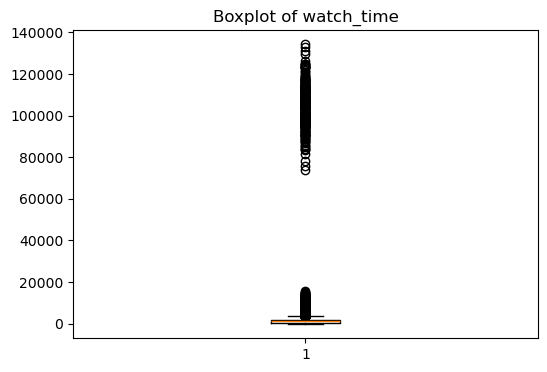

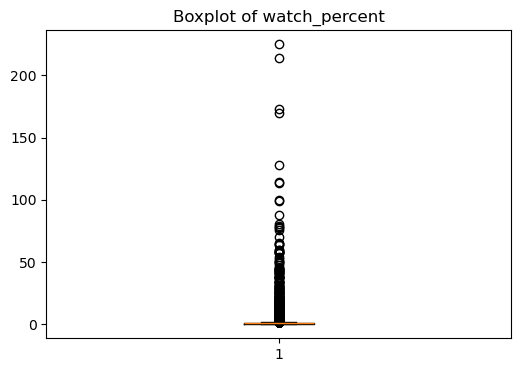

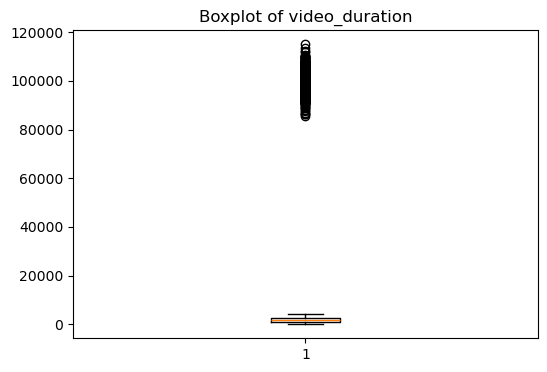

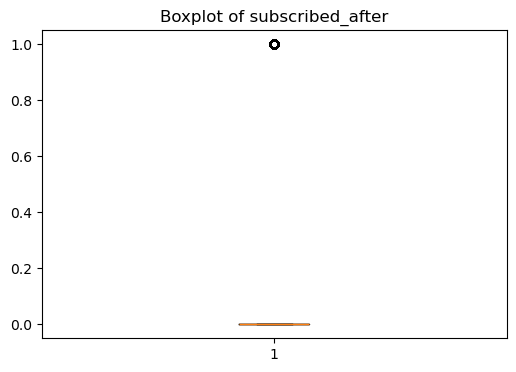

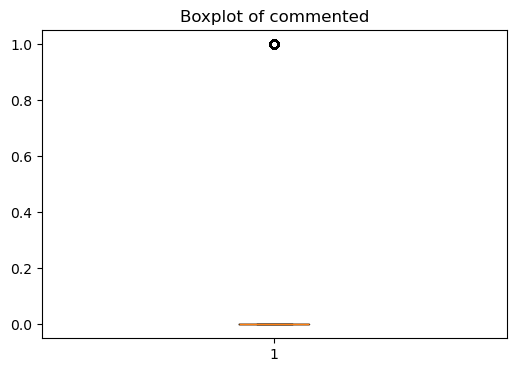

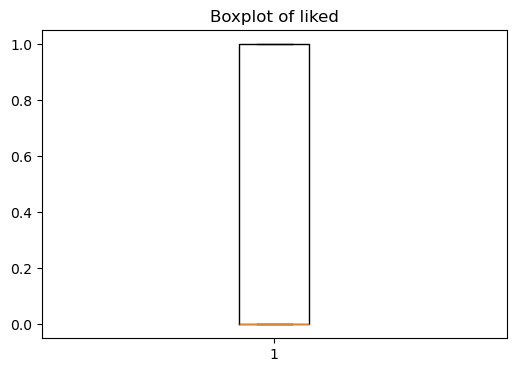

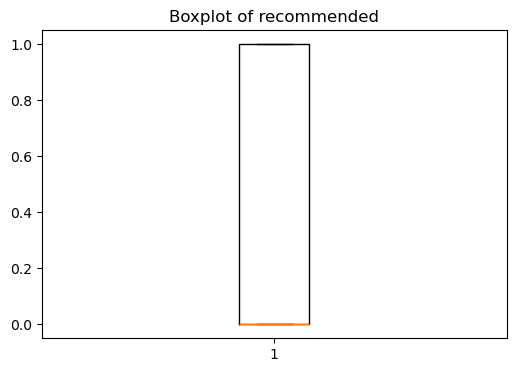

In [10]:
#outlier detection 
num_cols = ['watch_time', 'watch_percent', 'video_duration', 'subscribed_after','commented','liked','recommended']
for col in num_cols : 
    plt.figure(figsize=(6,4))
    plt.boxplot(train[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

A lot of outliers exist but some can be meaningful values so we will first figure out what the outliers are and then see which ones to cap 

In [12]:

q1 = train[num_cols].quantile(0.25)
q3 = train[num_cols].quantile(0.75)
iqr = q3 - q1
outlier_m= ((train[num_cols] < (q1 - 1.5 * iqr)) | (train[num_cols] > (q3 + 1.5 * iqr)))
outlier_c = outlier_m.sum().sort_values(ascending=False)
print(outlier_c)


commented           60837
subscribed_after    30647
watch_time           2770
watch_percent        2019
video_duration        604
liked                   0
recommended             0
dtype: int64


In [13]:
# outlier capping using IQR method

for col in num_cols:
    q1 = train[col].quantile(0.25)
    q3 = train[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    train[col] = np.clip(train[col], lower, upper)


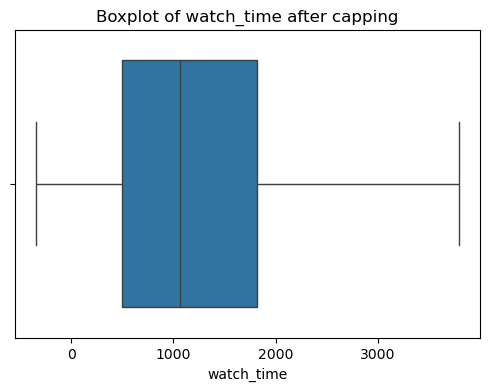

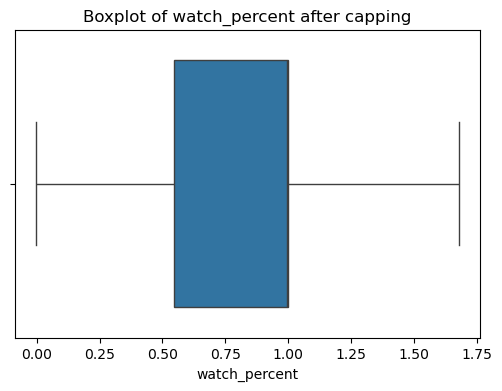

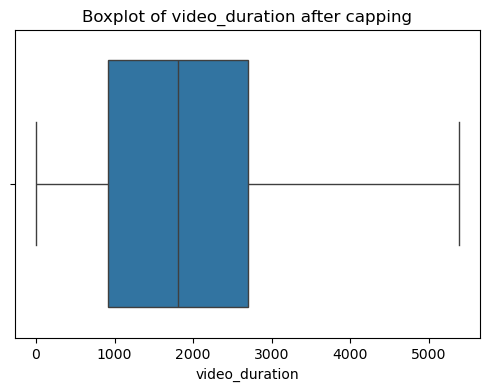

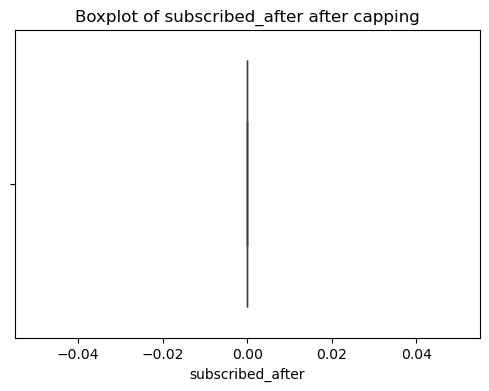

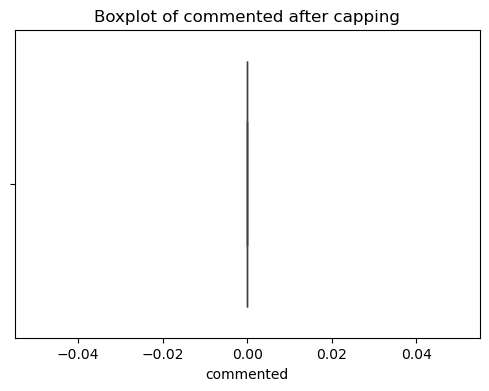

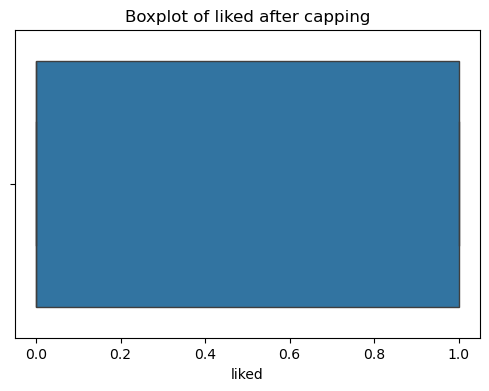

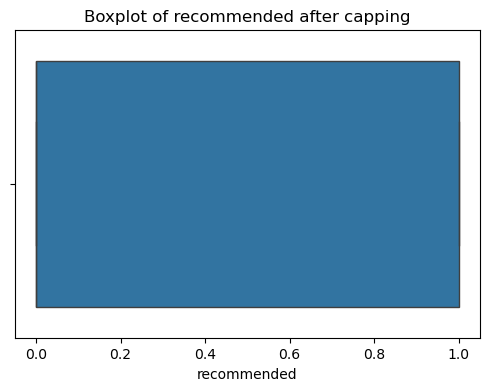

In [14]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=train[col])
    plt.title(f'Boxplot of {col} after capping')
    plt.show()


In [15]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

COLS_TO_ENCODE = ['device', 'category', 'watch_time_of_day']

encoders = {}

for col in COLS_TO_ENCODE:
    if col in train.columns and col in test.columns:
        le = LabelEncoder()
        all_values = pd.concat([
            train[col].astype(str), 
            test[col].astype(str)
        ], axis=0).unique()
        
        le.fit(all_values)
        
        new_col_name = col + '_encoded'
        train[new_col_name] = le.transform(train[col].astype(str))
        test[new_col_name] = le.transform(test[col].astype(str))
        train.drop(columns=[col], inplace=True)
        test.drop(columns=[col], inplace=True)
        
        encoders[col] = le
    

train.head(2)

,user_id,video_id,video_duration,watch_time,liked,commented,subscribed_after,recommended,clicked,timestamp,watch_percent,id,device_encoded,category_encoded,watch_time_of_day_encoded
0,59445,40936,1134.886052,1287.412446,1.0,0,0,1,0.0,2025-09-07 02:10:34,1.000000,283860,3,9,0
1,55829,17468,1335.223001,1224.760878,0.0,0,0,1,0.0,2025-09-22 04:16:24,0.996546,632997,1,4,3


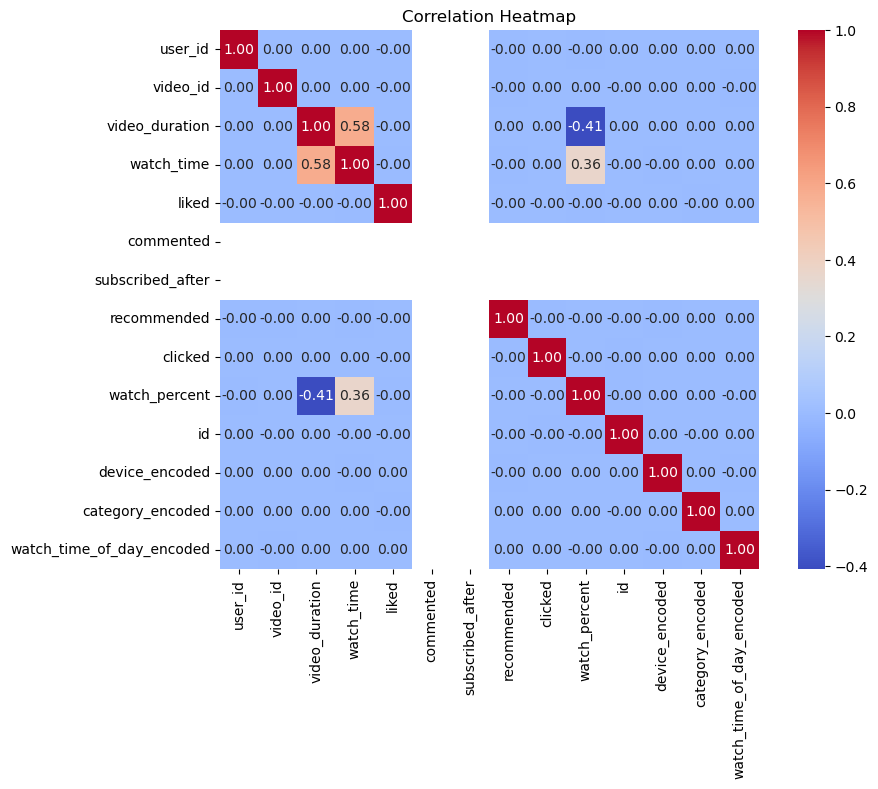

In [16]:
#visualising relationships and graphs to understand the dataset and feature importance
plt.figure(figsize=(10,7))
corr = train.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.show()

In [17]:
#trying to fix the white columns 
print(train[['liked', 'subscribed_after']].isna().sum())
print(train[['liked', 'subscribed_after']].nunique())
#fixed the 'liked' column issue but subscribed after is white because theres very less variation , its mostly 0 

liked               0
subscribed_after    0
dtype: int64
liked               2
subscribed_after    1
dtype: int64


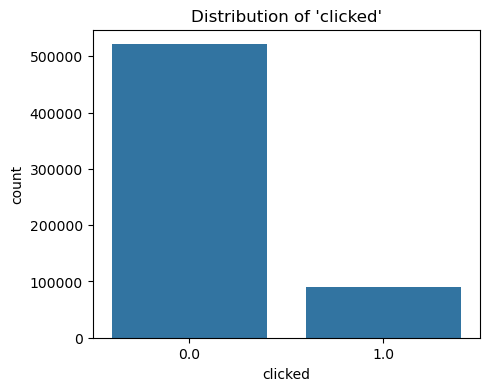

In [18]:
plt.figure(figsize=(5,4))
sns.countplot(x='clicked', data=train)
plt.title("Distribution of 'clicked'")
plt.show()


C:\Users\Twinkle\AppData\Local\Temp\ipykernel_32048\3272440874.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='clicked', y=col, data=train, palette='coolwarm')


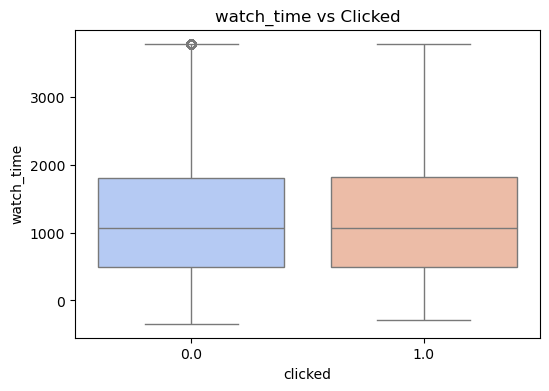

C:\Users\Twinkle\AppData\Local\Temp\ipykernel_32048\3272440874.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='clicked', y=col, data=train, palette='coolwarm')


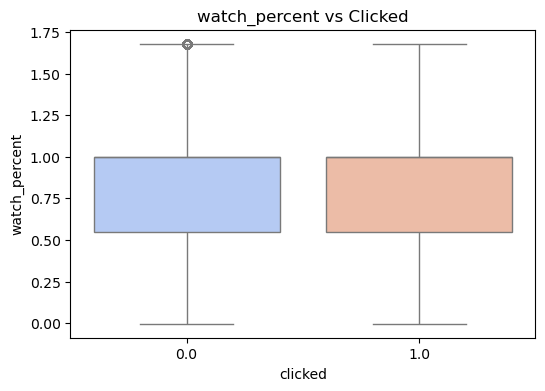

C:\Users\Twinkle\AppData\Local\Temp\ipykernel_32048\3272440874.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='clicked', y=col, data=train, palette='coolwarm')


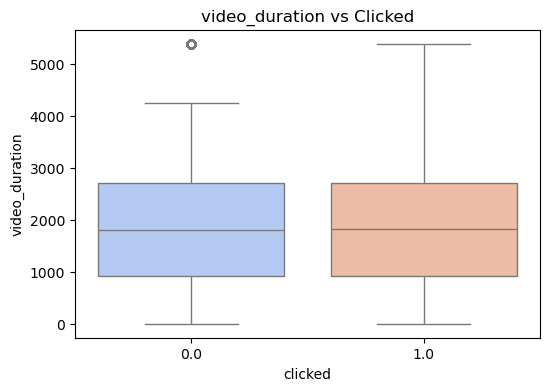

C:\Users\Twinkle\AppData\Local\Temp\ipykernel_32048\3272440874.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='clicked', y=col, data=train, palette='coolwarm')


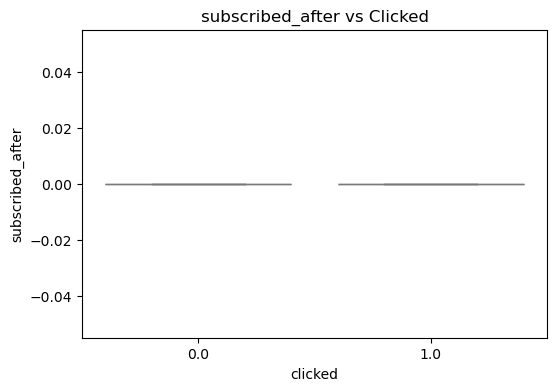

C:\Users\Twinkle\AppData\Local\Temp\ipykernel_32048\3272440874.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='clicked', y=col, data=train, palette='coolwarm')


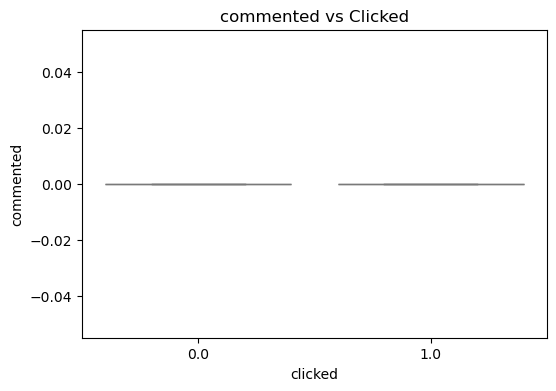

C:\Users\Twinkle\AppData\Local\Temp\ipykernel_32048\3272440874.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='clicked', y=col, data=train, palette='coolwarm')


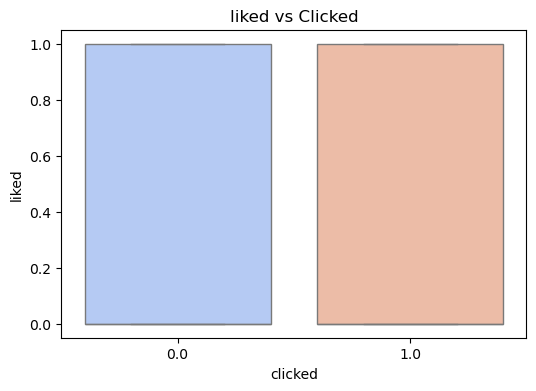

C:\Users\Twinkle\AppData\Local\Temp\ipykernel_32048\3272440874.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='clicked', y=col, data=train, palette='coolwarm')


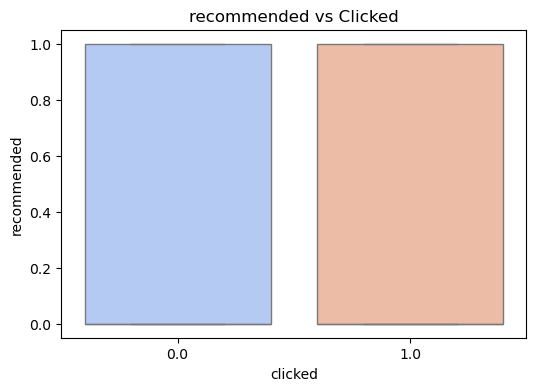

In [19]:

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='clicked', y=col, data=train, palette='coolwarm')
    plt.title(f'{col} vs Clicked')
    plt.show()


They are all heavily overlapping , trying a kde plot to cross check and if they overlap a lot that means individually these features dont help much in classification so we will try feature engineering next to derive meaningful features

In [21]:
#for col in categ_col:
#    plt.figure(figsize=(8,4))
#    sns.countplot(x=col, hue='clicked', data=train, palette='Set2')
#    plt.title(f'{col} vs Clicked')
#    plt.xticks(rotation=45)
#    plt.show()

watch_time: skewness = 0.65


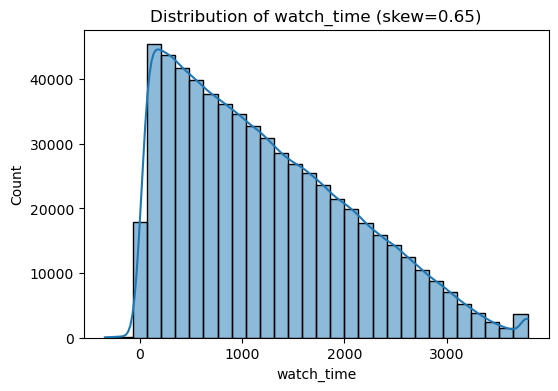

watch_percent: skewness = -0.97


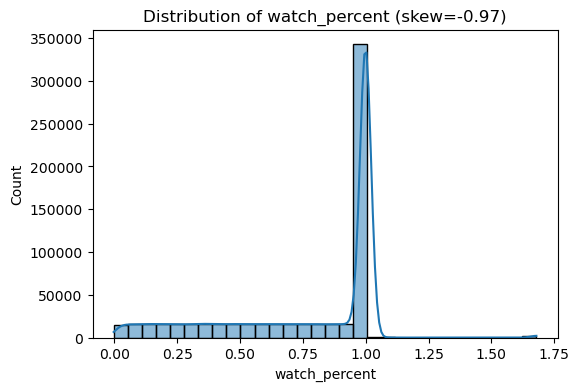

video_duration: skewness = 0.05


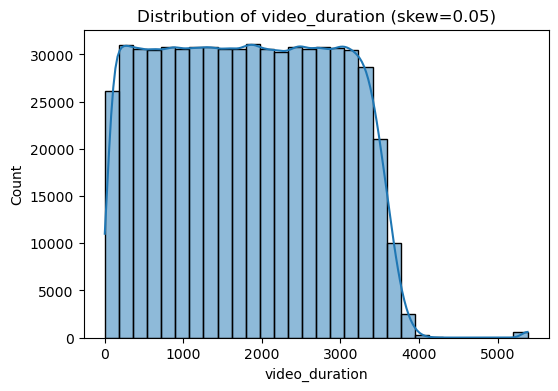

subscribed_after: skewness = nan


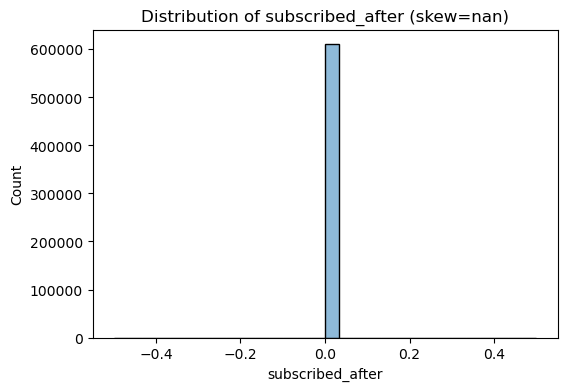

commented: skewness = nan


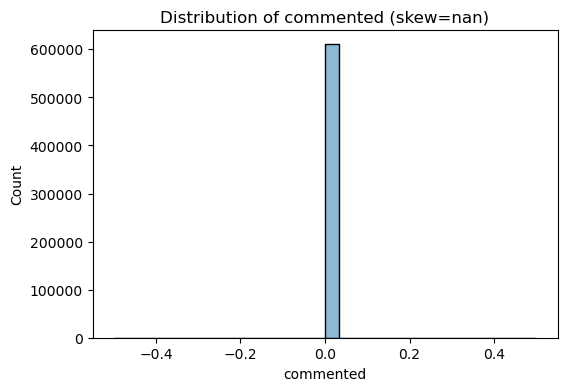

liked: skewness = 0.98


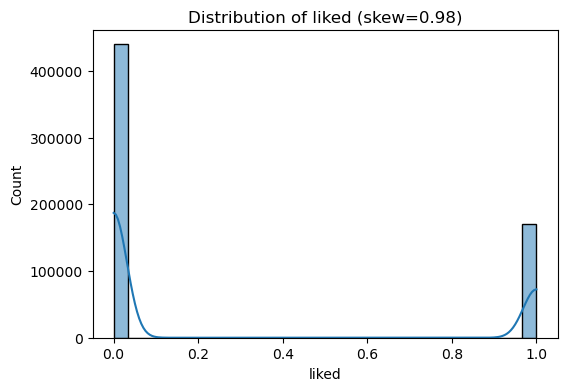

recommended: skewness = 0.41


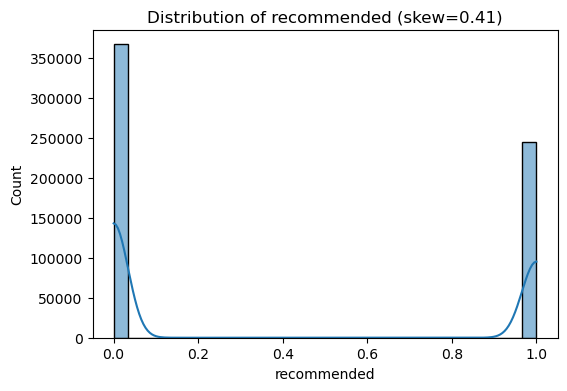

In [22]:
from scipy.stats import skew
for col in num_cols:
    sk = skew(train[col].dropna())
    print(f"{col}: skewness = {sk:.2f}")

    plt.figure(figsize=(6,4))
    sns.histplot(train[col], kde=True, bins=30)
    plt.title(f'Distribution of {col} (skew={sk:.2f})')
    plt.show()


In [23]:
#fixing highly skewed features 
train['watch_time']=np.log(train['watch_time'])

c = train['watch_percent'].max() + 1
train['watch_percent'] = np.sqrt(c - train['watch_percent'])

C:\Users\Twinkle\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [24]:
train['watch_time_x_device'] = train['watch_time'] * train['device_encoded']
train['category_x_device'] = train['category_encoded'] * train['device_encoded']
train['watch_time_x_category'] = train['watch_time'] * train['category_encoded']
train['engagement_rate'] = train['watch_time'] / train['video_duration']
train['effective_watch'] = train['watch_percent'] * train['video_duration']
train['watch_efficiency'] = train['watch_time'] / (train['video_duration'] + 1)

In [25]:
x = train.drop(columns=['clicked'])
y = train['clicked'].astype(int)

In [26]:
print("X shape:", x.shape)
print("y shape:", y.shape)


X shape: (610308, 20)
y shape: (610308,)


In [27]:

%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [28]:

from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from collections import Counter
import xgboost as xgb
x=x.drop(columns=['timestamp'])

x = x.replace([np.inf, -np.inf], np.nan)
x = x.fillna(x.median(numeric_only=True))

imputer = SimpleImputer(strategy='median')
x = pd.DataFrame(imputer.fit_transform(x), columns=x.columns)

X_train, X_valid, y_train, y_valid = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)

min_class_count = Counter(y_train)[min(Counter(y_train), key=Counter(y_train).get)]
k_neighbors = min(5, max(1, min_class_count - 1))

smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(pd.Series(y_train_res).value_counts())
X_train_res = np.array(X_train_res)
y_train_res = np.array(y_train_res)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)
params = {
    "objective": "binary:logistic",
    "eval_metric": "aucpr",    
    "learning_rate": 0.05,
    "max_depth": 7,
    "min_child_weight": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "n_estimators": 1200,
    "random_state": 42,
    "tree_method": "hist",
    "scale_pos_weight": (len(y_train_res) - sum(y_train_res)) / sum(y_train_res)  # handles imbalance
}

model = xgb.XGBClassifier(**params)
model.fit(
    X_train_res, y_train_res,
    eval_set=[(X_valid, y_valid)],
    verbose=False
)

y_probs_valid = model.predict_proba(X_valid)[:, 1]

best_t, best_f1 = 0.5, 0
for t in np.arange(0.3, 0.71, 0.01):
    preds_t = (y_probs_valid >= t).astype(int)
    f1 = f1_score(y_valid, preds_t)
    if f1 > best_f1:
        best_t, best_f1 = t, f1

print(f"\nBest Threshold: {best_t:.2f} , Validation F1 Score: {best_f1:.4f}\n")
y_pred_valid = (y_probs_valid >= best_t).astype(int)
print("Classification Report:\n", classification_report(y_valid, y_pred_valid))
print("\nConfusion Matrix:\n", confusion_matrix(y_valid, y_pred_valid))
importance = model.get_booster().get_score(importance_type="gain")
imp_df = pd.DataFrame({'Feature': list(importance.keys()), 'Importance': list(importance.values())})
imp_df = imp_df.sort_values(by="Importance", ascending=False)
print("\nTop 10 Features:\n", imp_df.head(10))


clicked
0    416872
1    416872
Name: count, dtype: int64

Best Threshold: 0.30 , Validation F1 Score: 0.0069

Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92    104218
           1       0.15      0.00      0.01     17844

    accuracy                           0.85    122062
   macro avg       0.50      0.50      0.46    122062
weighted avg       0.75      0.85      0.79    122062


Confusion Matrix:
 [[103873    345]
 [ 17781     63]]

Top 10 Features:
    Feature   Importance
8      f10  1056.507935
5       f7   895.144653
10     f12   461.980011
4       f4   406.606934
9      f11   178.919693
12     f14    23.450804
6       f8    15.859632
11     f13     8.249029
16     f18     6.502214
3       f3     6.220599


In [29]:
x = train.drop(columns=['clicked', 'timestamp'])
y = train['clicked']

In [30]:
corr = train.corr(numeric_only=True)['clicked'].sort_values(ascending=False)
print(corr.head(15))

clicked                      1.000000
category_x_device            0.002526
device_encoded               0.002394
watch_time_x_device          0.001990
effective_watch              0.001129
video_duration               0.001110
watch_time_of_day_encoded    0.000803
category_encoded             0.000739
video_id                     0.000668
watch_percent                0.000666
watch_time_x_category        0.000509
user_id                      0.000171
watch_time                  -0.000023
engagement_rate             -0.000243
liked                       -0.000430
Name: clicked, dtype: float64


In [31]:
train['clicked'].value_counts(normalize=True)
#there is a lot of 0's and much lesser 1's so there is huge imbalance in the target variable and the model does not predict it accurately.


clicked
0.0    0.853815
1.0    0.146185
Name: proportion, dtype: float64

In [32]:
print("Clicked values:", train["clicked"].unique())


Clicked values: [0. 1.]


In [33]:
print("Clicked values:", train["clicked"].unique())


Clicked values: [0. 1.]


In [34]:
#for submission 
print(test['liked'].unique())
print(test['subscribed_after'].unique())


['0' '1' nan 'yes' '2' 'no']
[0 1]


In [35]:
test['liked']=test['liked'].astype(str).str.lower().str.strip()
test['liked'] = test['liked'].map({'yes': 1, 'no': 0, '1': 1, '0': 0,'nan':np.nan,'2':np.nan})
test['liked'] = test['liked'].fillna(0)
test['watch_percent'] = test['watch_percent'].fillna(test['watch_percent'].median())

In [36]:
num_cols=test.select_dtypes(include=['int64','float64']).columns
q1 = test[num_cols].quantile(0.25)
q3 = test[num_cols].quantile(0.75)
iqr = q3 - q1
outlier_m= ((test[num_cols] < (q1 - 1.5 * iqr)) | (test[num_cols] > (q3 + 1.5 * iqr)))
outlier_c = outlier_m.sum().sort_values(ascending=False)
print(outlier_c)

commented           15075
subscribed_after     7604
watch_time            672
watch_percent         502
video_duration        170
user_id                 0
video_id                0
liked                   0
recommended             0
id                      0
dtype: int64


In [37]:
# outlier capping using IQR method
num_cols = ['watch_time', 'watch_percent', 'video_duration', 'subscribed_after']

for col in num_cols:
    q1 = train[col].quantile(0.25)
    q3 = train[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    train[col] = np.clip(train[col], lower, upper)


In [38]:
test['watch_time_x_device'] = test['watch_time'] * test['device_encoded']
test['category_x_device'] = test['category_encoded'] * test['device_encoded']
test['watch_time_x_category'] = test['watch_time'] * test['category_encoded']

test['engagement_rate'] = test['watch_time'] / test['video_duration']
test['effective_watch'] = test['watch_percent'] * test['video_duration']
test['watch_efficiency'] = test['watch_time'] / (test['video_duration'] + 1)

In [39]:
test_encoded = test.copy()

#for col in test_encoded.columns:
#    if col in encoders:
#        le = encoders[col]
#        test_encoded[col] = test_encoded[col].astype(str)
#        test_encoded[col] = test_encoded[col].apply(lambda x: x if x in le.classes_ else 'unknown')
#        if 'unknown' not in le.classes_:
#            le.classes_ = np.append(le.classes_, 'unknown')
#        test_encoded[col] = le.transform(test_encoded[col])


In [40]:
print(test.shape, x.shape)
print(test.columns.equals(x.columns))
print(test.head())


(152578, 20) (610308, 19)
False
   user_id  video_id  video_duration   watch_time  liked  commented  \
0    58237     29126     1576.253245  1670.503913    0.0          0   
1    29380      3736     1206.993190  1034.597609    1.0          0   
2    12024     25245     2354.700043   252.552926    0.0          1   
3    72445     12379      107.535828   104.482496    1.0          0   
4    58456      4051     2742.147252  1124.138486    0.0          0   

   subscribed_after  recommended            timestamp  watch_percent      id  \
0                 0            0  2024-08-09 21:43:46       1.000000   53363   
1                 0            0  2025-09-12 16:45:23       1.000000  293669   
2                 0            1  2025-01-17 05:01:14       0.103261   52195   
3                 0            1  2025-02-11 06:49:45       1.000000  260007   
4                 0            1  2024-01-17 01:08:03       0.433157  602213   

   device_encoded  category_encoded  watch_time_of_day_encod

In [41]:
sample

,id,clicked
0,1234,1
1,5678,0
2,9123,1


In [42]:
test=test.drop(columns=['timestamp'])
test = test.replace([np.inf, -np.inf], np.nan)
test = test.fillna(test.median(numeric_only=True))
test = pd.DataFrame(imputer.transform(test), columns=test.columns)

test_probs = model.predict_proba(test)[:, 1]
test_preds = (test_probs >= best_t).astype(int)

submission = pd.DataFrame({
    "id": test['id'] ,
    "clicked": test_preds
})
submission.to_csv("submission.csv", index=False)




In [43]:
submission.to_csv("submission.csv", index=False)


In [44]:
import os
os.getcwd()


'C:\\Users\\Twinkle\\Desktop'

In [45]:
from IPython.display import FileLink
FileLink('submission.csv')


C:\Users\Twinkle\Desktop\submission.csv